In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


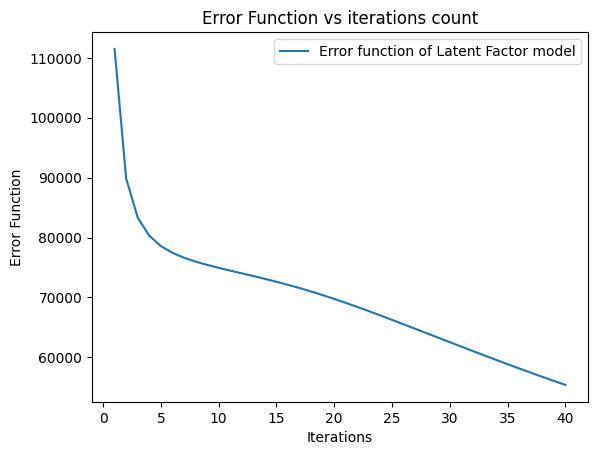

RMSE: 0.9142


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load training and test data using Pandas
train_df = pd.read_csv('/content/drive/MyDrive/netflix/netflix_recommendations/training_dataset.csv')
test_df = pd.read_csv('/content/drive/MyDrive/netflix/netflix_recommendations/test_dataset.csv')

# Filter header row
train_df = train_df[train_df['user_id'] != 'user_id']
test_df = test_df[test_df['user_id'] != 'user_id']

# Convert data to integers
train_df = train_df.astype({'user_id': int, 'item_id': int, 'rating': int})
test_df = test_df.astype({'user_id': int, 'item_id': int, 'rating': int})

# Find unique users and items
users = train_df['user_id'].unique()
items = train_df['item_id'].unique()

# Initialize hyperparameters
k = 25
lamda = 0.1
iterations = 40
learning_rate = 0.002

# Initialize P and Q matrices
max_users = max(users)
max_items = max(items)
P = np.random.rand(max_users, k) * (np.sqrt(5 / k))
Q = np.random.rand(max_items, k) * (np.sqrt(5 / k))

# Define regularization function
def regularization():
    p_norm = np.sum(P ** 2)
    q_norm = np.sum(Q ** 2)
    return p_norm, q_norm

# Define error calculation function
def calculating_error():
    error_part = np.sum((train_df['rating'] - np.sum(P[train_df['user_id'] - 1] * Q[train_df['item_id'] - 1], axis=1)) ** 2)
    users_norm, items_norm = regularization()
    error = error_part + (lamda * users_norm) + (lamda * items_norm)
    return error

# Train the model
error_per_iteration_cache = {}
for i in range(iterations):
    for _, row in train_df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        rating = row['rating']
        user_row = P[user_id - 1]
        item_row = Q[item_id - 1]
        P[user_id - 1] = user_row - learning_rate * ((lamda * user_row) - 2 * (rating - np.dot(user_row, item_row)) * item_row)
        Q[item_id - 1] = item_row - learning_rate * ((lamda * item_row) - 2 * (rating - np.dot(user_row, item_row)) * user_row)
    error_per_iteration_cache[i + 1] = calculating_error()

# Plot the error
iteration_counts = list(error_per_iteration_cache.keys())
error_per_iteration = list(error_per_iteration_cache.values())

plt.plot(iteration_counts, error_per_iteration, label="Error function of Latent Factor model")
plt.title("Error Function vs iterations count")
plt.xlabel("Iterations")
plt.ylabel("Error Function")
plt.legend(loc=0)
plt.show()

# Prepare test data
user_all_ratings = {user: [] for user in users}
for _, row in train_df.iterrows():
    user_id = row['user_id']
    rating = row['rating']
    user_all_ratings[user_id].append(rating)

average_user_rating = {user: np.mean(ratings) for user, ratings in user_all_ratings.items()}

predicted_ratings = []
actual_ratings = []

for _, row in test_df.iterrows():
    user_id = row['user_id']
    item_id = row['item_id']
    rating = row['rating']
    if item_id not in items:
        predicted_ratings.append(average_user_rating[user_id])
    else:
        predicted_ratings.append(np.dot(P[user_id - 1], Q[item_id - 1]))
    actual_ratings.append(rating)

# Calculate RMSE
def RMSE(y_actual, y_predicted):
    rms = sqrt(mean_squared_error(y_actual, y_predicted))
    return round(rms, 4)

rmse = RMSE(actual_ratings, predicted_ratings)
print("RMSE:", rmse)
